## Cleaning coordinates
Create a new column in the df with the 'gold standard' coordinates. These are coordinates in decimal degree format. Save as a csv for export to GEE. Sense-check each point, refine, and transfer final files (as csv and yaml) to Ben H. 

Where coordinates are explicitly available in papers, use these. Where not available, take 'location' and search for coordinates using Google Maps API. 

In [ ]:
### autoreload
%reload_ext autoreload
%autoreload 2

### imports
# general
import json
import pandas as pd
import numpy as np
import re
import googlemaps
from tqdm.auto import tqdm

# plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px
import plotly.graph_objects as go

# custom
from calcification import (
    locations,
    config,
    locations,
    utils,
    plotting,
    processing,
    file_ops,
)

In [ ]:
### load data
df = processing.process_raw_data(
    pd.read_excel(
        config.data_dir / "Orlando_data.xlsx",
        sheet_name="all_data",
    )
)


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0']
Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml


## Getting all locations (e.g. for climatology extraction)

In [ ]:
### generate unique dois and combine to get necessary locations
save_locations = False

all_locs_df = processing.populate_carbonate_chemistry(
    fp=config.data_dir / "Orlando_data.xlsx",
    sheet_name="all_data",
    selection_dict={"include": ["yes", "revisit", "check"]},
)

# append bioerosion locations
bioerosion_df = processing.populate_carbonate_chemistry(
    fp=config.data_dir / "Orlando_data.xlsx",
    sheet_name="bioerosion",
    selection_dict={"include": ["yes", "revisit", "check"]},
)

all_locations = pd.concat(
    [
        all_locs_df[["doi", "latitude", "longitude", "location"]],
        bioerosion_df[["doi", "latitude", "longitude", "location"]],
    ],
    ignore_index=True,
)
all_locations = all_locations.drop_duplicates(
    subset=["doi", "latitude", "longitude", "location"]
)

if save_locations:
    # save as csv
    all_locations.to_csv(config.resources_dir / "all_locations.csv", index=False)
    # prepare dataframe for writing to yaml (doi as key)
    all_locations_dict = all_locations.set_index("doi").T.to_dict()
    # save as yaml
    file_ops.write_yaml(all_locations_dict, config.resources_dir / "all_locations.yaml")


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0']
Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml
Missing units in mapping: [nan 'ug CaCO3 mm-2' '%/day' '%growth week-1']
Loading measured values...


Calculating carbonate chemistry:   0%|          | 0/6115 [00:00<?, ?it/s]

Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml
Loading measured values...


Calculating carbonate chemistry:   0%|          | 0/91 [00:00<?, ?it/s]

## Visualising spatial distribution of studies

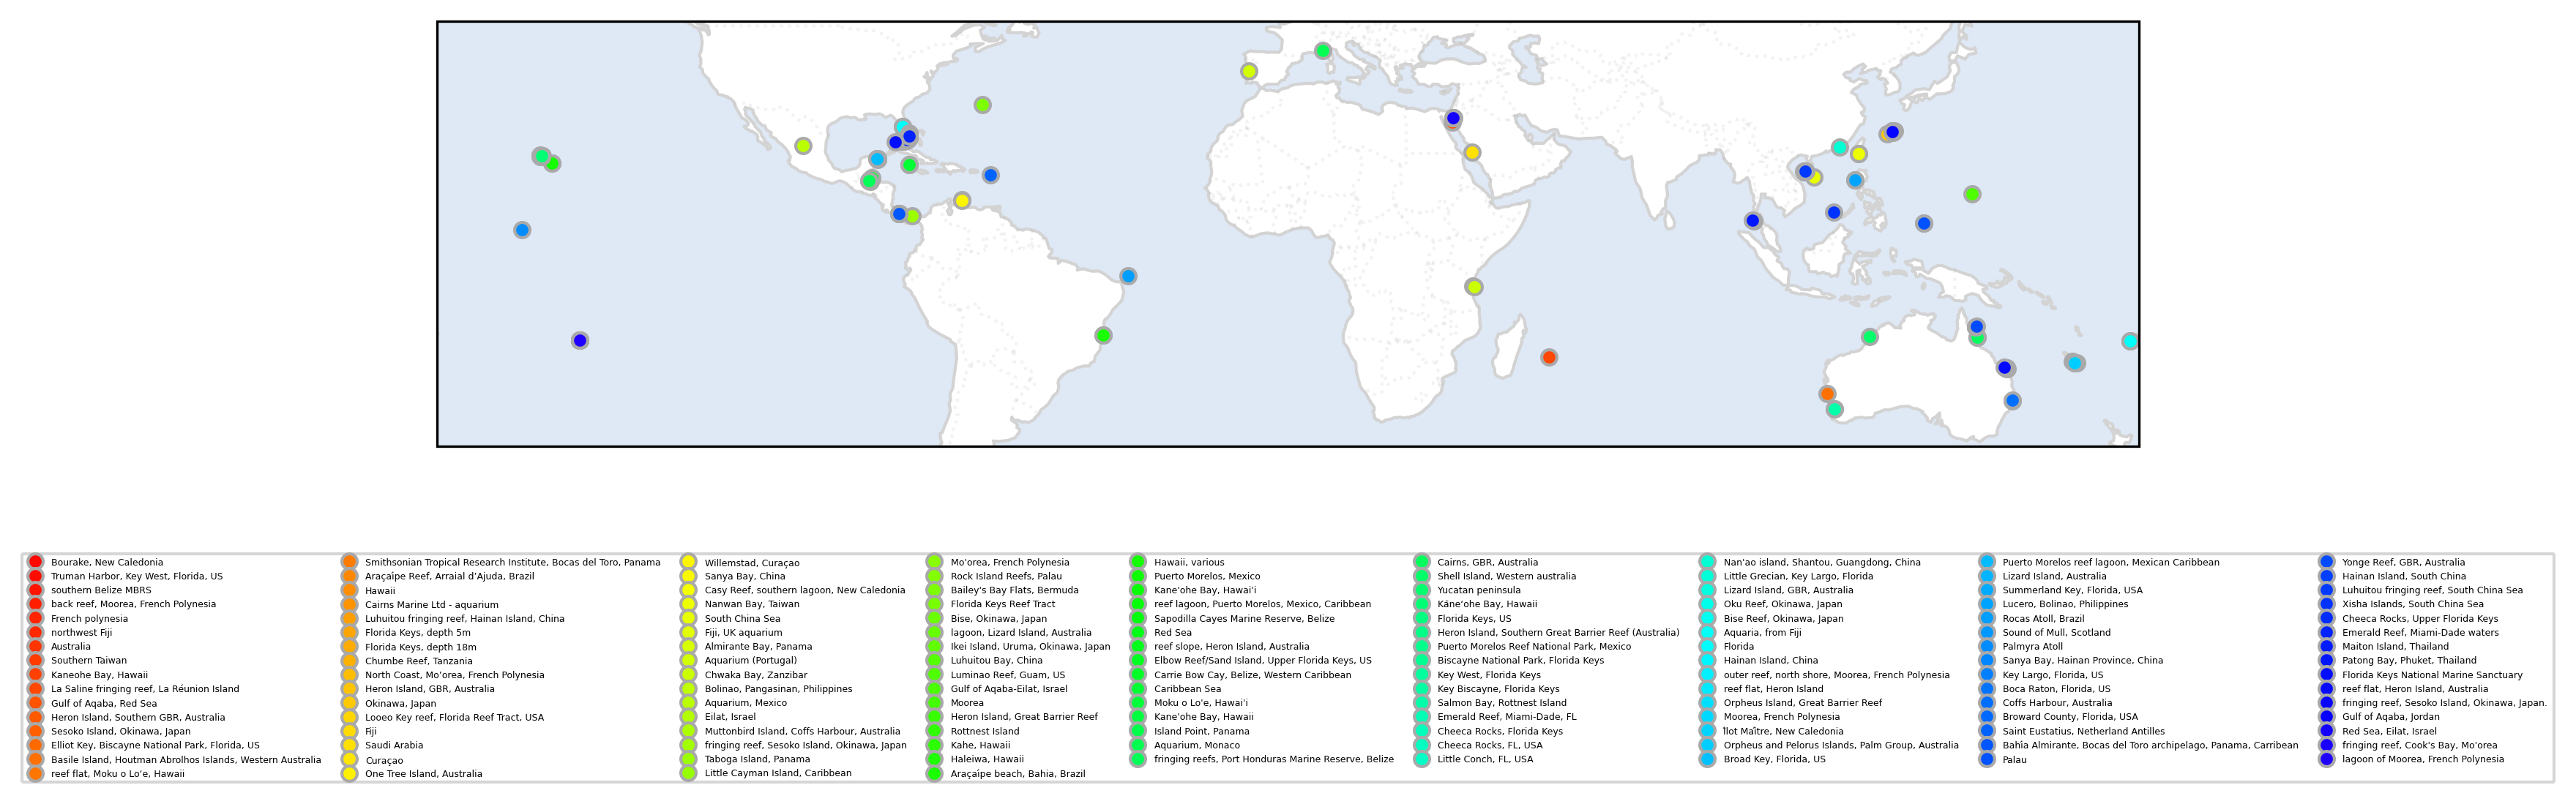

In [ ]:
### plot spatial disribution of studies
locs = file_ops.read_yaml(
    config.resources_dir / "all_locations.yaml"
)  # read locations.yaml
locs_df = pd.DataFrame(locs).T
locs_df = locs_df.dropna()

# create and format map
fig, ax = plt.subplots(
    1, 1, figsize=(10, 20), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300
)
ax = plotting.format_geo_axes(ax)

# add locations with colors
colors = sns.color_palette("hsv", len(locs_df))
locations_to_plot = locs_df.drop_duplicates("location")
for i, (doi, row) in enumerate(locations_to_plot.iterrows()):
    data = locs[doi]
    ax.plot(
        data["longitude"],
        data["latitude"],
        "o",
        markeredgecolor="darkgrey",
        markersize=5,
        color=colors[i],
        transform=ccrs.PlateCarree(),
        label=data["location"],
    )

ax.legend(
    loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=len(locs_df) // 20, fontsize=3
);  # add legend

## Applying ocean climatology areas

In [ ]:
### read in bioerosion locations
bioerosion_df = processing.populate_carbonate_chemistry(
    fp=config.data_dir / "Orlando_data.xlsx",
    sheet_name="bioerosion",
    selection_dict={"include": "yes"},
)
bioerosion_df = bioerosion_df.drop_duplicates(subset=["latitude", "longitude"])

Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml
Loading measured values...


Calculating carbonate chemistry:   0%|          | 0/83 [00:00<?, ?it/s]

In [10]:
### load marine climatological area shapefiles dir
shp_dir_fp = config.climatology_data_dir / "MEOW"
# read in shapefiles from directory
gdf = gpd.read_file(shp_dir_fp / "meow_ecos.shp")
tropical_areas_df = gdf[gdf["Lat_Zone"] == "Tropical"]

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


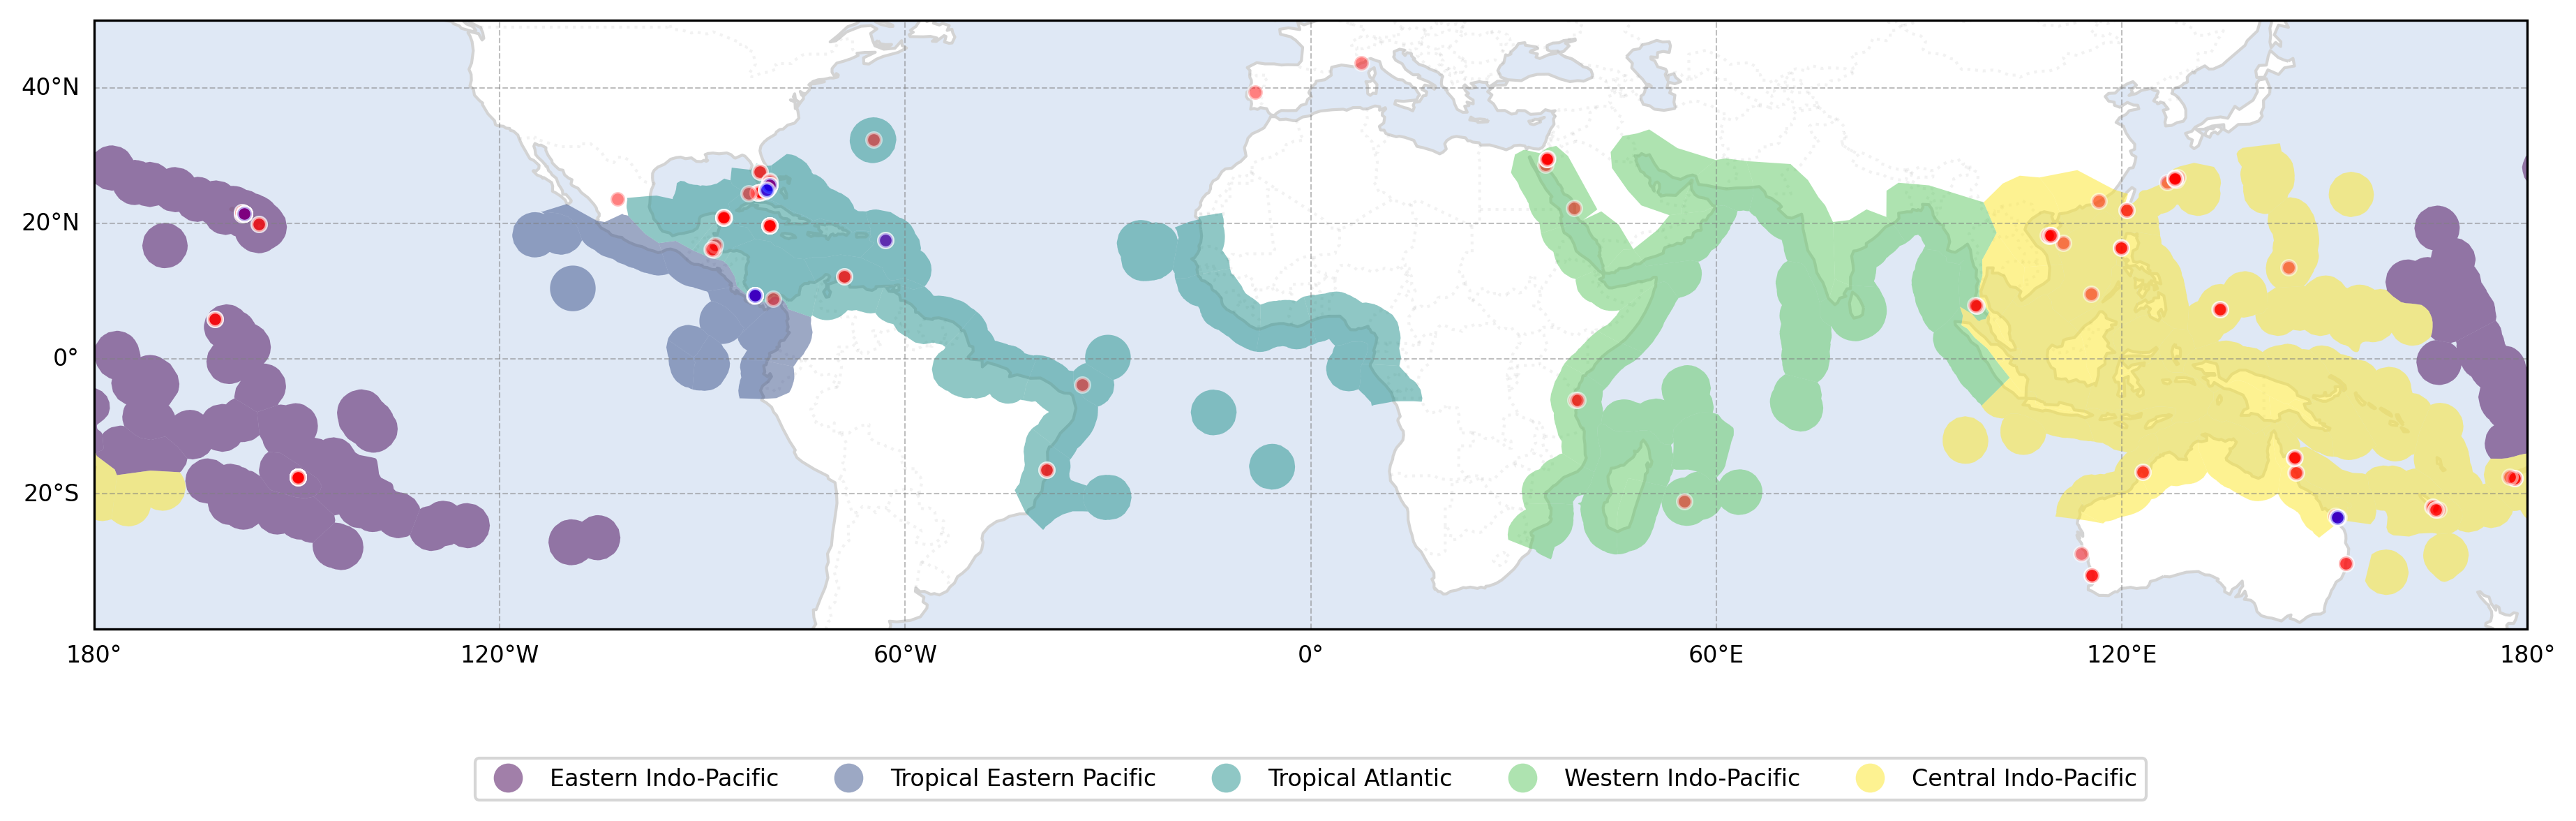

In [ ]:
# set the desired order for the legend labels
legend_order = [
    "Eastern Indo-Pacific",
    "Tropical Eastern Pacific",
    "Tropical Atlantic",
    "Western Indo-Pacific",
    "Central Indo-Pacific",
]

# convert the 'REALM' column to a categorical type with the specified order
tropical_areas_df["REALM"] = pd.Categorical(
    tropical_areas_df["REALM"], categories=legend_order, ordered=True
)
tropical_areas_df = tropical_areas_df.sort_values("REALM")

# create plot
fig, ax = plt.subplots(
    1, 1, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300
)
ax = plotting.format_geo_axes(ax)

# plot tropical ocean areas
tropical_areas_df.plot(
    ax=ax,
    column="REALM",
    legend=True,
    cmap="viridis",
    alpha=0.5,
    legend_kwds={
        "bbox_to_anchor": (0.5, -0.3),
        "ncol": len(legend_order),
        "loc": "lower center",
        "fontsize": 8,
    },
)

# plot site locations of calcification experiments
for i, (doi, data) in enumerate(locs_df.iterrows()):
    # convert coordinates to float if necessary # TODO: this shouldn't be necessary
    lat = (
        float(data["latitude"])
        if isinstance(data["latitude"], str)
        else data["latitude"]
    )
    lon = (
        float(data["longitude"])
        if isinstance(data["longitude"], str)
        else data["longitude"]
    )
    # Ignore invalid coordinates
    if pd.notna(lat) and pd.notna(lon):
        ax.plot(
            lon,
            lat,
            "o",
            markeredgecolor="white",
            markersize=5,
            alpha=0.5,
            zorder=100,
            color="red",
            transform=ccrs.PlateCarree(),
        )

for i, (doi, data) in enumerate(bioerosion_df.iterrows()):
    # Convert coordinates to float if necessary
    lat = (
        float(data["latitude"])
        if isinstance(data["latitude"], str)
        else data["latitude"]
    )
    lon = (
        float(data["longitude"])
        if isinstance(data["longitude"], str)
        else data["longitude"]
    )
    # Ignore invalid coordinates
    if pd.notna(lat) and pd.notna(lon):
        ax.plot(
            lon,
            lat,
            "o",
            markeredgecolor="white",
            markersize=5,
            alpha=0.5,
            zorder=100,
            color="blue",
            transform=ccrs.PlateCarree(),
        )

# Format
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--"
)
gl.xlabel_style = {"size": 8}
gl.ylabel_style = {"size": 8}
gl.top_labels = False
gl.right_labels = False

In [21]:
### prepare data for interactive plot of spatial distribution of oceanic realms
temp_tropical_areas_df = tropical_areas_df.copy()
# convert to robinson projection for more accurate calculations
temp_tropical_areas_df.loc[:, "geometry_projected"] = (
    temp_tropical_areas_df.geometry.to_crs("ESRI:54034")
)  # convert
temp_tropical_areas_df.loc[:, "centroid_projected"] = temp_tropical_areas_df[
    "geometry_projected"
].centroid  # calculate centroid
temp_tropical_areas_df.loc[:, "centroid"] = temp_tropical_areas_df[
    "centroid_projected"
].to_crs("EPSG:4326")  # convert back to lat/lon
temp_tropical_areas_df.loc[:, "centroid_lat"] = temp_tropical_areas_df["centroid"].y
temp_tropical_areas_df.loc[:, "centroid_lon"] = temp_tropical_areas_df["centroid"].x
# drop intermediate columns to keep dataframe clean
centroids_df = temp_tropical_areas_df[["RLM_CODE", "centroid_lat", "centroid_lon"]]
# group by realm code and take the median lat/lon to get the centroid of each realm
centroids_df = centroids_df.groupby("RLM_CODE").median()

# add column of realm names to centroids df
centroids_df["realm_name"] = centroids_df.index.map(
    tropical_areas_df.set_index("RLM_CODE")["REALM"].to_dict()
)

### get the realm for each location in locs_df based on their coordinates
# cast value to numeric (e.g. if string somehow)
locs_df["latitude"] = pd.to_numeric(locs_df["latitude"], errors="coerce")
locs_df["longitude"] = pd.to_numeric(locs_df["longitude"], errors="coerce")
# create point geometry object from latitude and longitude
points_geometry = [
    Point(lon, lat) if pd.notna(lon) and pd.notna(lat) else None
    for lon, lat in zip(locs_df["longitude"], locs_df["latitude"])
]
points_gdf = gpd.GeoDataFrame(locs_df, geometry=points_geometry, crs="EPSG:4326")
# join on geometry to match with realms
joined = gpd.sjoin(
    points_gdf, tropical_areas_df[["REALM", "geometry"]], how="left", predicate="within"
)

# assign realm to column in locs_df
locs_df["realm"] = joined["REALM"]

In [22]:
### plot interactive world map with study locations
locations_to_plot = locs_df.copy()

locations_to_plot.loc[:, "latitude"] = pd.to_numeric(locations_to_plot["latitude"])
locations_to_plot.loc[:, "longitude"] = pd.to_numeric(locations_to_plot["longitude"])
locations_to_plot.loc[:, "hover_text"] = list(locations_to_plot.index)

fig = go.Figure()

# add high-resolution base map layer
fig.add_trace(
    go.Scattergeo(
        lon=[None],
        lat=[None],
        mode="markers",
        marker_opacity=0,
        showlegend=False,
    )
)

# convert tropical areas to GeoJSON for plotting
tropical_geojson = json.loads(tropical_areas_df.to_json())

# add the ocean areas as choropleth layer
fig.add_trace(
    go.Choropleth(
        geojson=tropical_geojson,
        locations=tropical_areas_df.index,
        z=tropical_areas_df.RLM_CODE,  # colour by realm code
        colorscale="Viridis",
        marker_opacity=0.4,
        marker_line_width=0.5,
        marker_line_color="white",
        showscale=False,
        hoverinfo="text",
        hovertext=[
            f"{row.ECOREGION} - {row.REALM}" for _, row in tropical_areas_df.iterrows()
        ],
        name="Tropical Marine Ecoregions",
    )
)

# assign each realm a colour
realm_colors = {
    "Central Indo-Pacific": "#1f77b4",
    "Eastern Indo-Pacific": "#ff7f0e",
    "Western Indo-Pacific": "#2ca02c",
    "Tropical Atlantic": "#d62728",
    "Tropical Eastern Pacific": "#9467bd",
}

# interactively plot each realm
for realm in locations_to_plot["realm"].dropna().unique():
    subset = locations_to_plot[locations_to_plot["realm"] == realm]
    fig.add_trace(
        go.Scattergeo(
            lon=subset["longitude"],
            lat=subset["latitude"],
            text=subset["location"],
            mode="markers",
            marker=dict(
                size=8,
                opacity=0.8,
                color=realm_colors.get(realm, "red"),
                line=dict(width=1, color="white"),
            ),
            hovertemplate="<b>%{text}</b><br>DOI: %{customdata}<br>Lat: %{lat:.4f}<br>Lon: %{lon:.4f}<br>Realm: "
            + realm,
            customdata=subset.index,
            name=realm,
        )
    )

no_realm = locations_to_plot[
    (
        locations_to_plot["realm"].isna()
        | locations_to_plot["location"].str.contains("aquari", case=False)
    )
]  # determine aquaria locations
# plot aquaria locations as crosses
if len(no_realm) > 0:
    fig.add_trace(
        go.Scattergeo(
            lon=no_realm["longitude"],
            lat=no_realm["latitude"],
            text=no_realm["location"],
            mode="markers",
            marker=dict(size=8, opacity=0.8, color="black", symbol="x"),
            hovertemplate="<b>%{text}</b><br>DOI: %{customdata}<br>Lat: %{lat:.4f}<br>Lon: %{lon:.4f}<br>Realm: Aquarium species",
            customdata=no_realm.index,
            name="Unknown Realm (aquarium species)",
        )
    )

# annotate realms at their centroids
fig.add_trace(
    go.Scattergeo(
        lon=centroids_df["centroid_lon"],
        lat=centroids_df["centroid_lat"],
        text=centroids_df["realm_name"],
        mode="text",
        textfont=dict(size=14, color="#2b2b2b", family="Arial Black"),
        textposition="middle center",
        hoverinfo="none",
        showlegend=False,  # don't create a legend: this would be overkill
    )
)

# format
fig.update_geos(
    lataxis_range=[-40, 40],
    lonaxis_range=[-180, 180],
    showland=True,
    landcolor="rgb(240,240,240)",
    showocean=True,
    oceancolor="rgb(230, 250, 255)",
    showcoastlines=True,
    coastlinecolor="rgb(80, 80, 80)",
    coastlinewidth=0.5,
    showframe=True,
    framecolor="gray",
    showcountries=True,
    countrycolor="rgb(150,150,150)",
    countrywidth=0.5,
    showlakes=True,
    lakecolor="rgb(230, 250, 255)",
    showrivers=True,
    rivercolor="rgb(230, 250, 255)",
    resolution=50,
    projection_type="natural earth",
)

fig.update_layout(
    title={
        "text": "Spatial Distribution of Studies in Tropical Marine Ecoregions",
        "font": {"size": 20, "family": "Arial"},
        "x": 0.5,
        "y": 0.95,
    },
    margin=dict(l=0, r=0, t=60, b=0),
    height=700,
    width=1500,
    legend=dict(
        x=0.01,
        y=0.01,
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="gray",
        borderwidth=1,
    ),
    geo=dict(bgcolor="rgba(255,255,255,0)"),
    template="plotly_white",
    showlegend=True,
)

fig.show()

# Author locations

In [23]:
### make dictionary of authors and their affiliations

author_list = [
    "Oscar Branson <ob266@cam.ac.uk>",
    "Verena Schoepf <v.schoepf@uva.nl>",
    "Steeve Comeau <steeve.comeau@imev-mer.fr>",
    "Ben Harvey <ben.harvey@shimoda.tsukuba.ac.jp>",
    "Travis A Courtney <travis.courtney@upr.edu>",
    "Andreas Andersson <aandersson@ucsd.edu>",
    "Ian Enochs <ian.enochs@noaa.gov>",
    "Chris Perry <C.Perry@exeter.ac.uk>",
    "Alice Webb <A.E.Webb@exeter.ac.uk>",
    "Lauren Toth <ltoth@usgs.gov>",
    "Simon Donner <simon.donner@ubc.ca>",
    "Cheryl Logan <CLogan@csumb.edu>",
    "Denisa Berbece <denisa.berbece@vuw.ac.nz>",
    "Ashtyn Isaak <ashtyn.isaak@vuw.ac.nz>",
    "Holly Koch <holly.koch@vuw.ac.nz>",
    "Orlando Timmerman <rt582@cam.ac.uk>",
]

affiliation_map = {
    "cam": "Cambridge",
    "uva": "Amsterdam",
    "imev-mer": "Sorbonne University",
    "shimoda": "Shimoda, Japan",
    "upr": "Puerto Rico",
    "ucsd": "UC San Diego",
    "exeter": "Exeter",
    "usgs": "St. Petersburg, Florida",
    "ubc": "University of British Columbia",
    "csumb": "California State University, Monterey Bay",
    "vuw": "Victoria University of Wellington, New Zealand",
    "noaa": "NOAA, Miami",
}

affiliations = {}
for author in author_list:
    author_parts = author.split("<")
    name = author_parts[0].strip()
    email = author_parts[1].replace(">", "").strip()
    domain = email.split("@")[1]
    affiliation_key = domain.split(".")[0]

    # Initialize the dictionary for each author
    affiliations[name] = {
        "email": email,
        "affiliation": affiliation_map.get(affiliation_key, affiliation_key),
    }

In [24]:
### get locations for authors via google maps API
gmaps_coords = {}
GMAPS_API_KEY = file_ops.read_yaml(config.resources_dir / "api_keys.yaml")[
    "google_maps_api"
]
gmaps_client = googlemaps.Client(key=GMAPS_API_KEY)

locs = [affiliations[person]["affiliation"] for person in list(affiliations.keys())]
for loc in tqdm(locs, desc="Querying Google Maps to retrieve coordinates of locations"):
    gmaps_coords[loc] = tuple(
        locations.get_coord_pair_from_google_maps(loc, gmaps_client).values
    )

# add coordinates to affiliations dictionary
for author in affiliations.keys():
    affiliations[author]["coordinates"] = gmaps_coords[
        affiliations[author]["affiliation"]
    ]
affiliations_df = pd.DataFrame(affiliations).T
affiliations_df

Querying Google Maps to retrieve coordinates of locations:   0%|          | 0/16 [00:00<?, ?it/s]

,email,affiliation,coordinates
Oscar Branson,ob266@cam.ac.uk,Cambridge,"(52.1950788, 0.1312729)"
Verena Schoepf,v.schoepf@uva.nl,Amsterdam,"(52.3675734, 4.9041389)"
Steeve Comeau,steeve.comeau@imev-mer.fr,Sorbonne University,"(48.84695, 2.3555697)"
Ben Harvey,ben.harvey@shimoda.tsukuba.ac.jp,"Shimoda, Japan","(34.6796171, 138.9451459)"
Travis A Courtney,travis.courtney@upr.edu,Puerto Rico,"(18.220833, -66.590149)"
Andreas Andersson,aandersson@ucsd.edu,UC San Diego,"(32.881168, -117.2343605)"
Ian Enochs,ian.enochs@noaa.gov,"NOAA, Miami","(25.7616798, -80.1917902)"
Chris Perry,C.Perry@exeter.ac.uk,Exeter,"(None, None)"
Alice Webb,A.E.Webb@exeter.ac.uk,Exeter,"(None, None)"
Lauren Toth,ltoth@usgs.gov,"St. Petersburg, Florida","(27.7671271, -82.6384451)"


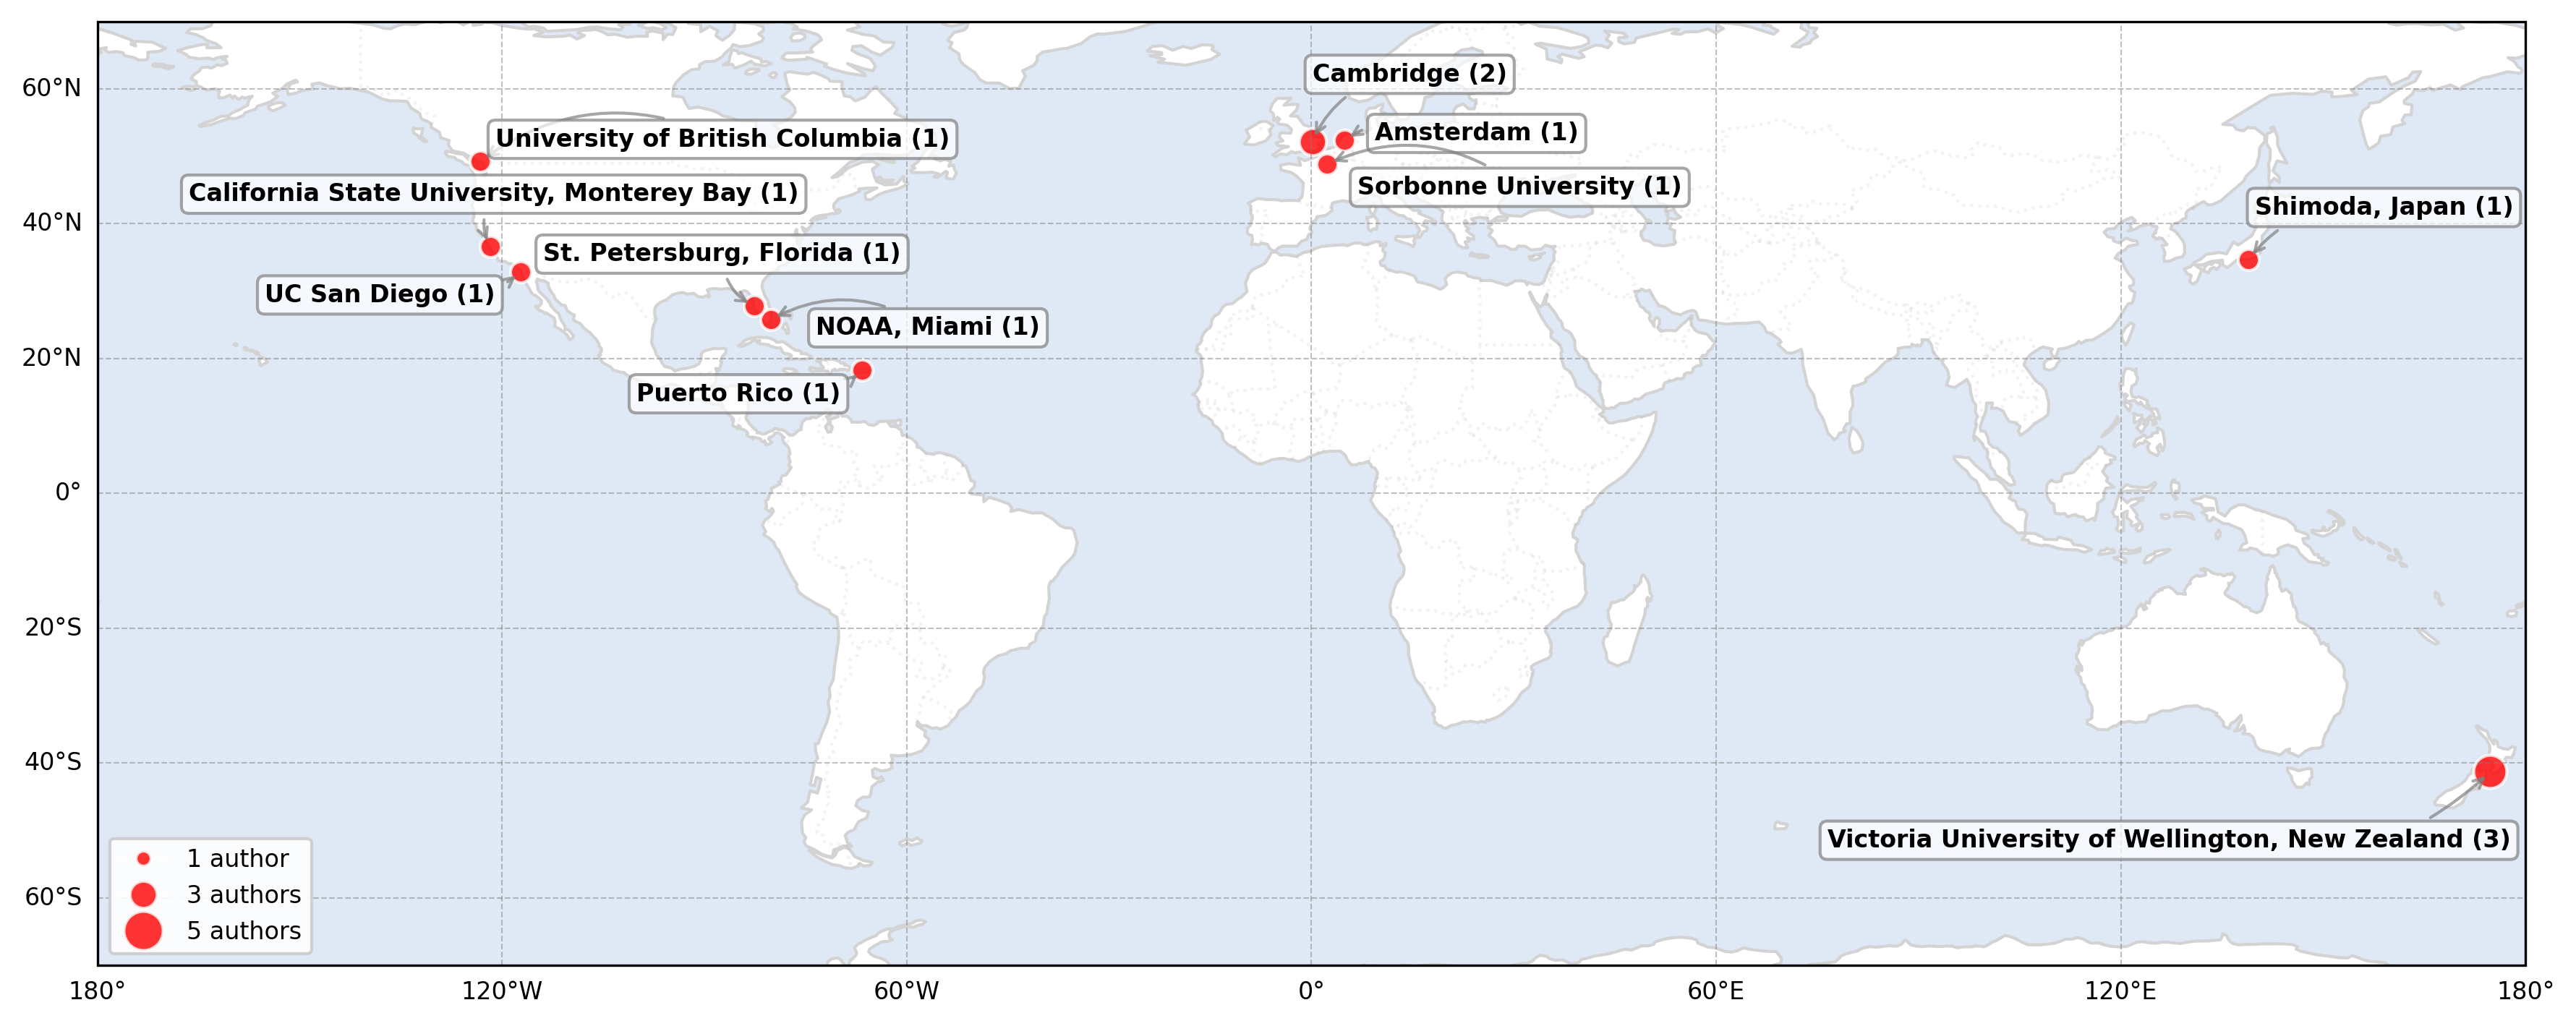

In [25]:
### plot on map with clean annotations

# plot worldmap
fig, ax = plt.subplots(
    1, 1, figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300
)
ax = plotting.format_geo_axes(ax, extent=[-180, 180, -70, 70])

# count number of authors at each location to size markers accordingly
location_count = {}
for i, data in affiliations_df.iterrows():
    loc = data["coordinates"]
    if loc in location_count:
        location_count[loc] += 1
    else:
        location_count[loc] = 1

# define offsets to prevent label overlapping (these are adjusted manually)
# format is (lat, lon): (x_offset, y_offset)
offsets = {
    (52.1950788, 0.1312729): (0, 20),  # Cambridge
    (52.3675734, 4.9041389): (10, 0),  # Amsterdam
    (50.72603669999999, -3.5274889): (-60, -10),  # Exeter
    (48.84695, 2.3555697): (10, -10),  # Sorbonne
    (38.0335529, -78.5079772): (5, -15),  # UVA
    (34.6796171, 138.9451459): (2, 15),  # Shimoda
    (18.220833, -66.590149): (-75, -10),  # Puerto Rico
    (32.881168, -117.2343605): (-85, -10),  # UC San Diego
    (25.7616798, -80.1917902): (15, -5),  # NOAA Miami
    (27.7671271, -82.6384451): (-70, 15),  # St. Petersburg
    (49.26060520000001, -123.2459939): (-40, 15),  # UBC
    (36.653712, -121.7989787): (-100, 15),  # CSUMB
    (-41.2923814, 174.7787463): (-220, -25),  # Victoria University
}

# plot each location once with size based on number of authors
plotted_locations = set()
for i, (index, data) in enumerate(affiliations_df.iterrows()):
    loc = data["coordinates"]
    if loc not in plotted_locations and pd.notna(loc[0]) and pd.notna(loc[1]):
        size = (
            5 + location_count[loc] * 2
        )  # size based on number of authors at this location
        ax.plot(
            loc[1],
            loc[0],
            "o",
            markeredgecolor="white",
            markersize=size,
            color="red",
            transform=ccrs.PlateCarree(),
            alpha=0.8,
        )

        # prepare annotation
        authors_at_loc = [
            idx for idx, row in affiliations_df.iterrows() if row["coordinates"] == loc
        ]
        author_count = len(authors_at_loc)
        x_offset, y_offset = offsets.get(loc, (5, 5))
        affiliation_text = data["affiliation"]

        ax.annotate(
            f"{affiliation_text} ({author_count})",
            xy=(loc[1], loc[0]),
            xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
            xytext=(x_offset, y_offset),
            textcoords="offset points",
            fontsize=8,
            color="black",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
            arrowprops=dict(
                arrowstyle="->", connectionstyle="arc3,rad=0.3", color="gray", alpha=0.7
            ),
        )

        plotted_locations.add(loc)

# format
# ax.set_title('Spatial Distribution of Authors', fontsize=16)
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--"
)
gl.xlabel_style = {"size": 8}
gl.ylabel_style = {"size": 8}
gl.top_labels = False
gl.right_labels = False

# add legend for marker size
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="red",
        markersize=5,
        label="1 author",
        alpha=0.8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="red",
        markersize=9,
        label="3 authors",
        alpha=0.8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="red",
        markersize=13,
        label="5 authors",
        alpha=0.8,
    ),
]
ax.legend(
    handles=legend_elements, loc="lower left", frameon=True, framealpha=0.9, fontsize=8
)

plt.tight_layout()